In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
from matplotlib.animation import FuncAnimation, PillowWriter
from train import set_args
from src.unet import ContextUnet
from src.ddpm import DDPM

In [2]:
# arguments
args = set_args()

# model
model = ContextUnet(
    in_channels=1, 
    n_feat=args.n_feat, 
    n_classes=args.n_classes
).to(args.device)

ddpm = DDPM(
    model=model, 
    betas=args.betas, 
    n_T=args.n_T, 
    drop_prob=args.drop_prob
)

# load weight
paths = glob(os.path.join(args.save_dir, "*.pth"))
ddpm.load_state_dict(
    torch.load(paths[-1], map_location=args.device)
)
ddpm.eval()
print("All keys matched successfully")

All keys matched successfully


100%|██████████| 400/400 [00:13<00:00, 28.73it/s]


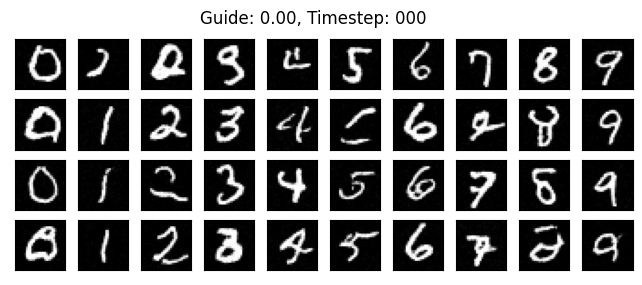

100%|██████████| 400/400 [00:12<00:00, 31.29it/s]


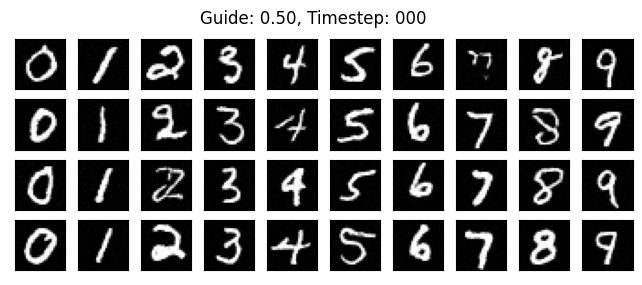

100%|██████████| 400/400 [00:12<00:00, 31.42it/s]


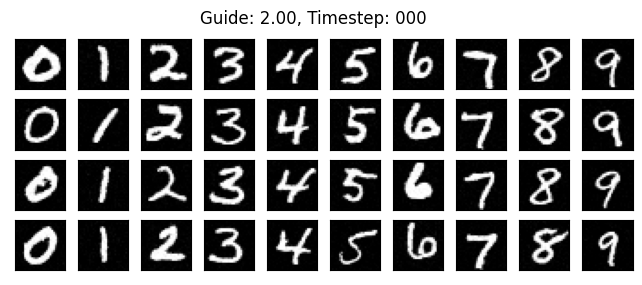

In [3]:
for w in [0.0, 0.5, 2.0]:
    # inference
    x, store = ddpm.sample(
        n_sample=40,
        size=(1, 28, 28),
        n_classes=10, 
        guide_w=w
    )

    # clip
    store = np.clip(store, 0, 1)

    # animate
    step = 10
    fig, axs = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(8,3))

    def animate_diff(i, store):
        plots = []
        fig.suptitle(f"Guide: {w:.2f}, Timestep: {400-i*step:03d}") 
        for row in range(4):
            for col in range(10):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i, (row*10)+col, 0], cmap="gray",vmin=0, vmax=1))
        return plots

    draw = np.append(store[::step], store[-1:], axis=0)

    ani = FuncAnimation(fig, animate_diff, fargs=[draw], interval=200, blit=False, repeat=True, frames=len(draw))
    ani.save(f"result_guide_{w:.2f}.gif", dpi=100, writer=PillowWriter(fps=60))
    plt.show()